# Earthquake seismology with DAS

Figure 5 from Ajo-Franklin et al 2019:
https://www.nature.com/articles/s41598-018-36675-8

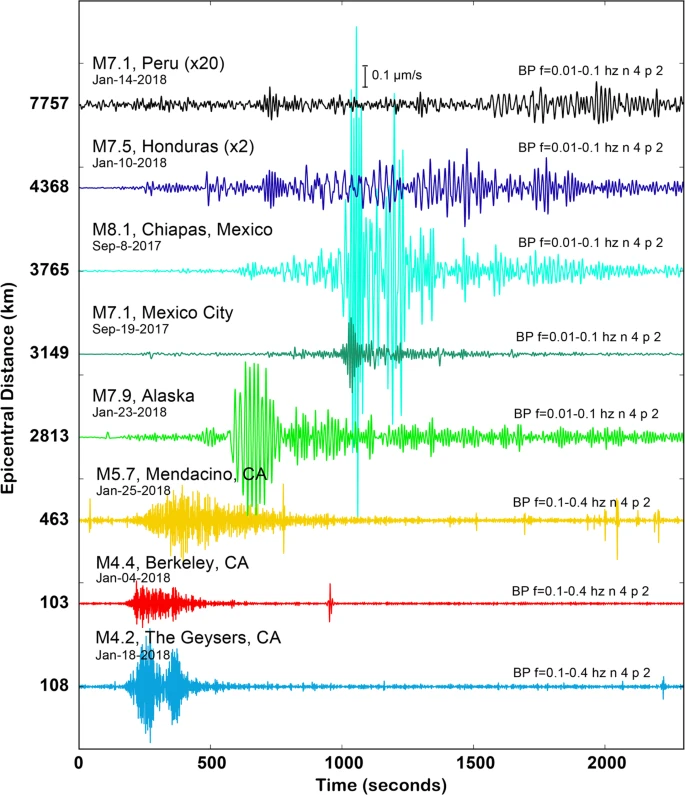

In [1]:
import h5py
import matplotlib.pyplot as plt
# %matplotlib notebook
from scipy.signal import butter, filtfilt
import numpy as np
import datetime

import matplotlib.dates as mdates

from dasquakes import sintela_to_datetime, open_sintela_file

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

pth ='/data/data0/seadasn/'
title=''

# Default filter parameters: Good for teleseisms
low_cut = 0.05
hi_cut = 1

chmin = 40
chanmax = 100

# M 3.4 - Puget Sound
https://pnsn.org/event/61832097#overview

In [2]:
# /data/data0/seadasn/seadasn_2022-05-17_08-07-00_UTC_029697.h5
title = 'M3.4 - 25.5 km NNE from Granite Falls, WA - Tue May 17, 2022 08:07:34 (UTC)'
file_base_name = 'seadasn'
sample_rate = 100
file_number = 29697
t0 = datetime.datetime(2022,5,17,8,7,0)
file_duration = 1
dt = datetime.timedelta(minutes=file_duration)
number_of_files = 3

low_cut = 2
hi_cut = 9
chmin = 1
chanmax = 1749

# M 3.6 - Puget Sound

https://pnsn.org/event/61835766#overview

In [3]:
# # /data/data0/seadasn/seadasn_2022-05-01_11-15-00_UTC_006856.h5
# title = 'M3.6 Sun May 1, 2022 04:15:56 AM (PDT)'
# file_base_name = 'seadasn'
# sample_rate = 100
# file_number = 6856
# t0 = datetime.datetime(2022,5,1,11,15,0)
# file_duration = 1
# dt = datetime.timedelta(minutes=file_duration)
# number_of_files = 2

# low_cut = 2
# hi_cut = 9
# chmin = 450
# chanmax = 650

# M 6.7 - 58 km WSW of Masachapa, Nicaragua
### 2022-04-21 07:42:46 (UTC)11.554°N 86.992°W25.3 km depth

http://ds.iris.edu/wilber3/find_stations/11552089
https://earthquake.usgs.gov/earthquakes/eventpage/us6000hf75/executive

In [4]:
# title = 'mww6.7 Near Coast Of Nicaragua'
# file_base_name = 'seadasn'
# sample_rate = 100
# file_number = 8617
# t0 = datetime.datetime(2022,4,21,7,42,0)
# file_duration = 1
# dt = datetime.timedelta(minutes=file_duration)
# number_of_files = 50
# low_cut = 0.04
# hi_cut = 0.1

# M 5.1 - off the coast of Oregon
### 2022-03-27 01:12:21 (UTC)44.117°N 129.452°W10.0 km depth
https://earthquake.usgs.gov/earthquakes/eventpage/us7000gxl1/executive

In [5]:
# title = 'M 5.1 - off the coast of Oregon -- 2022-03-27 01:12:21 (UTC)'
# file_base_name = 'seadasn'
# sample_rate = 100
# file_number = 7105
# t0 = datetime.datetime(2022,3,27,1,12,0)
# file_duration = 1
# dt = datetime.timedelta(minutes=file_duration)
# number_of_files = 10

# Good for local earthquakes
# low_cut = 0.01
# hi_cut = 10

# 2022-03-16 Japan M7.1

In [6]:
# file_base_name = 'convert-to-hdf5'
# sample_rate = 533.33
# file_number = 583
# t0 = datetime.datetime(2022,3,16,14,46,0)
# file_duration = 1
# dt = datetime.timedelta(minutes=file_duration)
# number_of_files = 10
# low_cut = 0.05
# hi_cut = 1

# 2022-03-30 New Caledonia M 6.9
http://ds.iris.edu/wilber3/find_stations/11544990

In [7]:
# first_filename = 'seadasn_2022-03-30_21-15-00_UTC_005083.h5'
# file_base_name = 'seadasn'
# sample_rate = 100
# file_number = 5077
# t0 = datetime.datetime(2022,3,30,21,9,0)
# dt = datetime.timedelta(minutes=1)
# number_of_files = 60
# file_duration = 1

# 2022-03-31 New Caledonia M 7.0

In [8]:
# file_base_name = 'seadasn'
# sample_rate = 100
# file_number = 5592
# t0 = datetime.datetime(2022,3,31,5,44,0)
# dt = datetime.timedelta(minutes=1)
# number_of_files = 75
# file_duration = 1

In [9]:
data,time = open_sintela_file(file_base_name,number_of_files,
                              sample_rate,file_duration,t0,file_number,pth,dt,
                             chmin,chanmax)
dates = sintela_to_datetime(time)

In [10]:
b,a = butter(2,(low_cut,hi_cut),'bp',fs=sample_rate)
data_filt = filtfilt(b,a,data,axis=0)

In [11]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
t2 = UTCDateTime( (t0+number_of_files*dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
st.decimate(5, strict_length=False, no_filter=False)
#everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "BH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.COR.00.BH1 | 2022-05-17T08:07:00.019538Z - 2022-05-17T08:09:59.994538Z | 40.0 Hz, 7200 samples

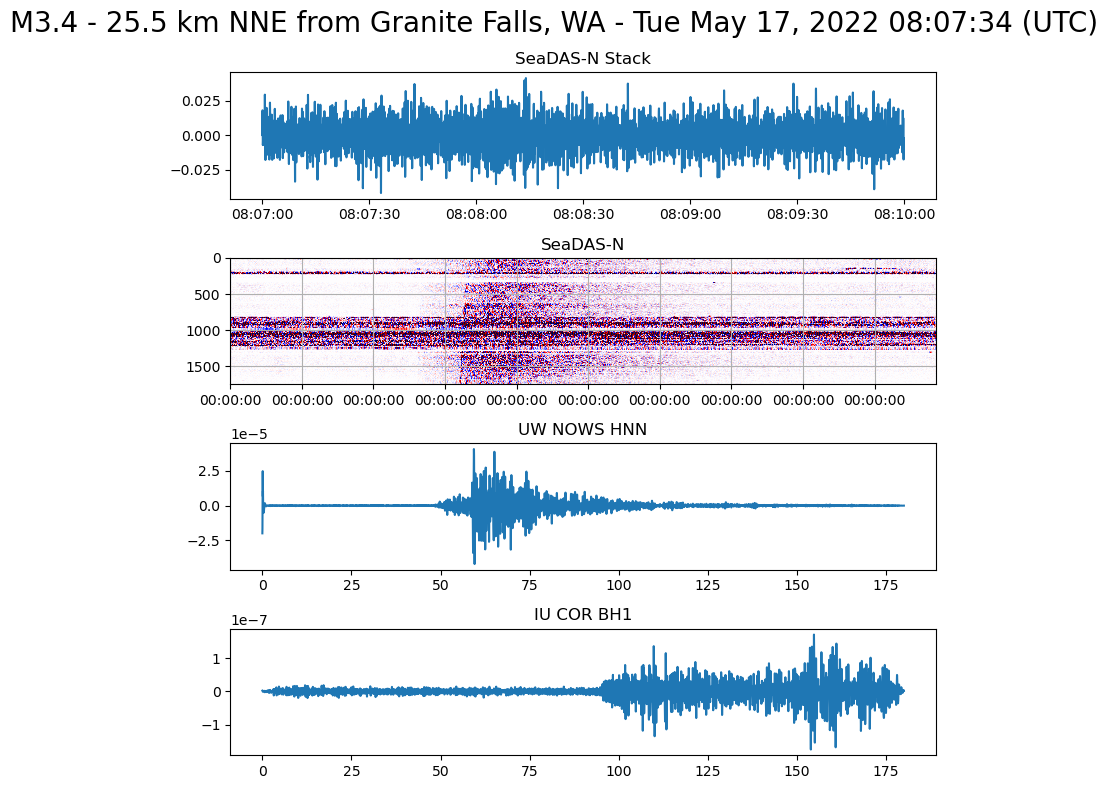

In [12]:

fig,ax=plt.subplots(figsize=(8,8))
plt.title(title,fontsize=12)
ax = plt.subplot(4,1,1)

fig.patch.set_facecolor('w')
exx = np.mean(data_filt,axis=1)
t = np.array([time-time[0]]).flatten()/1e6
plt.plot(dates,exx)
ax.set_title('SeaDAS-N Stack')

ax=plt.subplot(4,1,2)
ax.set_title('SeaDAS-N')
plt.imshow(data_filt.T,vmin=-0.1,vmax=0.1,cmap='seismic',aspect='auto',
          )
# extent=[dates[0],dates[-1],chmin,chanmax]
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
plt.grid()

ax = plt.subplot(4,1,3)
for tr in st:
    plt.plot(tr.times(),tr.data)
fig.patch.set_facecolor('w')
ax.set_title('UW NOWS HNN')

ax = plt.subplot(4,1,4)
for tr in st2:
    plt.plot(tr.times(),tr.data)
fig.patch.set_facecolor('w')
ax.set_title('IU COR BH1')

fig.suptitle(title,fontsize=20)
plt.tight_layout()
plt.show()

In [13]:
data_filt.shape

(18000, 1748)

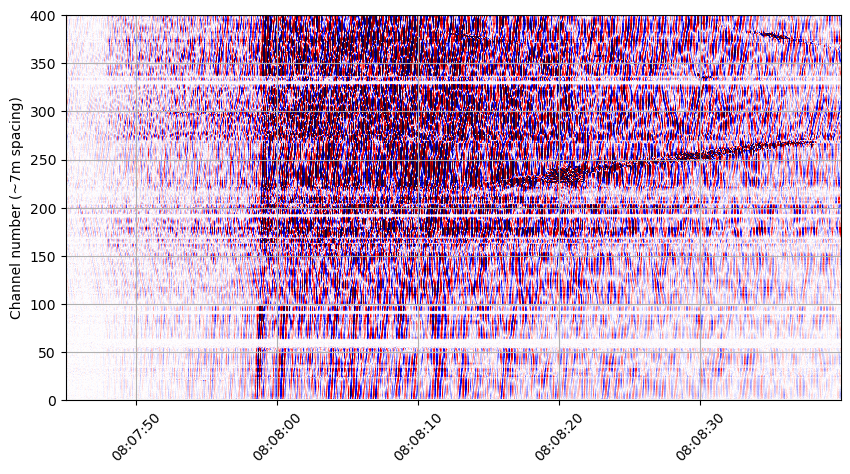

In [14]:
x_lims = mdates.date2num(dates)

fig,ax=plt.subplots(figsize=(10,5))

plt.imshow(data_filt.T,vmin=-0.15,vmax=0.15,cmap='seismic',aspect='auto',
         extent=[x_lims[0],x_lims[-1],chmin,chanmax])
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation = 45)

plt.ylim([0,400])
plt.xlim([dates[4500],dates[10000]])

plt.ylabel('Channel number (~7m spacing)')

plt.grid()
plt.show()

# What if we stack only those with high xcorr?

In [15]:
from time import perf_counter
nchan = chanmax - chmin

if nchan < 201: # at 200, takes 172s to run
    my_rho = np.zeros((nchan,nchan))
    pcounter_start = perf_counter()

    for j in range(nchan):
        for i in range(nchan):
            my_rho[i,j] = np.corrcoef(data_filt[:,j], data_filt[:,i])[0,1]
    pcounter_stop = perf_counter()        
    print('Execution time is %f'%(pcounter_stop-pcounter_start))
    mxc = np.argmax(np.sum(my_rho,axis=1))
    print('Channel with the strongest correlations: %d'%mxc)
    
    
    fig,ax=plt.subplots()
    plt.imshow(my_rho)
    ax.plot( np.mean(my_rho,axis=1) )
    ax.set_title('Sum of correlations along an axis')
    plt.tight_layout()
    plt.show()

    
else:
    print('Not calculating full xc matrix')
    mxc = 105
    my_rho = np.zeros((nchan,1))
    pcounter_start = perf_counter()

    for i in range(nchan):
        my_rho[i] = np.corrcoef(data_filt[:,64], data_filt[:,i])[0,1]
    pcounter_stop = perf_counter()        
    print('Execution time is %f'%(pcounter_stop-pcounter_start))

Not calculating full xc matrix
Execution time is 0.751889


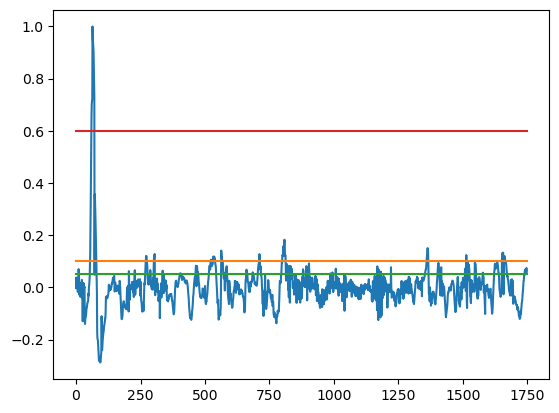

The Channel with the highest xcor: 105


In [16]:
fig,ax=plt.subplots()

ax.plot( np.average(my_rho,axis=1) )
# ax.set_ylim([0,0.25])
ax.plot([0,nchan],[0.1,0.1])
ax.plot([0,nchan],[0.05,0.05])
ax.plot([0,nchan],[0.6,0.6])
plt.show()
print('The Channel with the highest xcor: %d'%mxc)

In [17]:
data_filt_good_channels = data_filt[:,(np.mean(my_rho,axis=1) > 0.05).flatten()]
exx_cc = np.mean( data_filt_good_channels  ,axis=1)

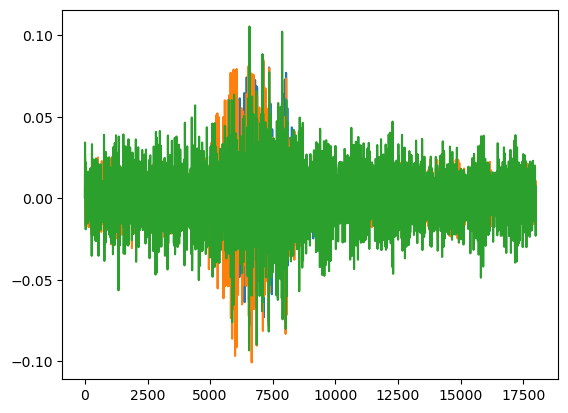

In [18]:
plt.subplots()
for thr in [0.1,0.05,0.01]:
    plt.plot(np.mean( data_filt[:,(np.mean(my_rho,axis=1) > thr).flatten()]  ,axis=1))
plt.show()

# Convert phase measurements to velocity

In [19]:
# Convert phase to strain

nc = 1.4682
gl = 10
psi = 0.79
lmbda = 1550.12e-9
factor = lmbda / (4*np.pi * nc*gl*psi)
print(factor)

1.0635138367380394e-08


In [20]:
# Integrate strain to get displacement
ux_all = factor * np.cumsum(data_filt_good_channels,axis=1) * gl
ux = factor * np.mean(np.cumsum(data_filt_good_channels,axis=1),axis=1) * gl

In [21]:
# Take time derivative of displacement to get velocity
tmax = 60*number_of_files
t_vec = np.linspace(0,tmax,len(ux))
dt = t_vec[1] - t_vec[0]
print(dt)
vx = np.gradient(ux, dt)
vx_all = np.gradient(ux_all, dt,axis=0)
vx_same = np.mean(vx_all,axis=1)

0.0100005555864


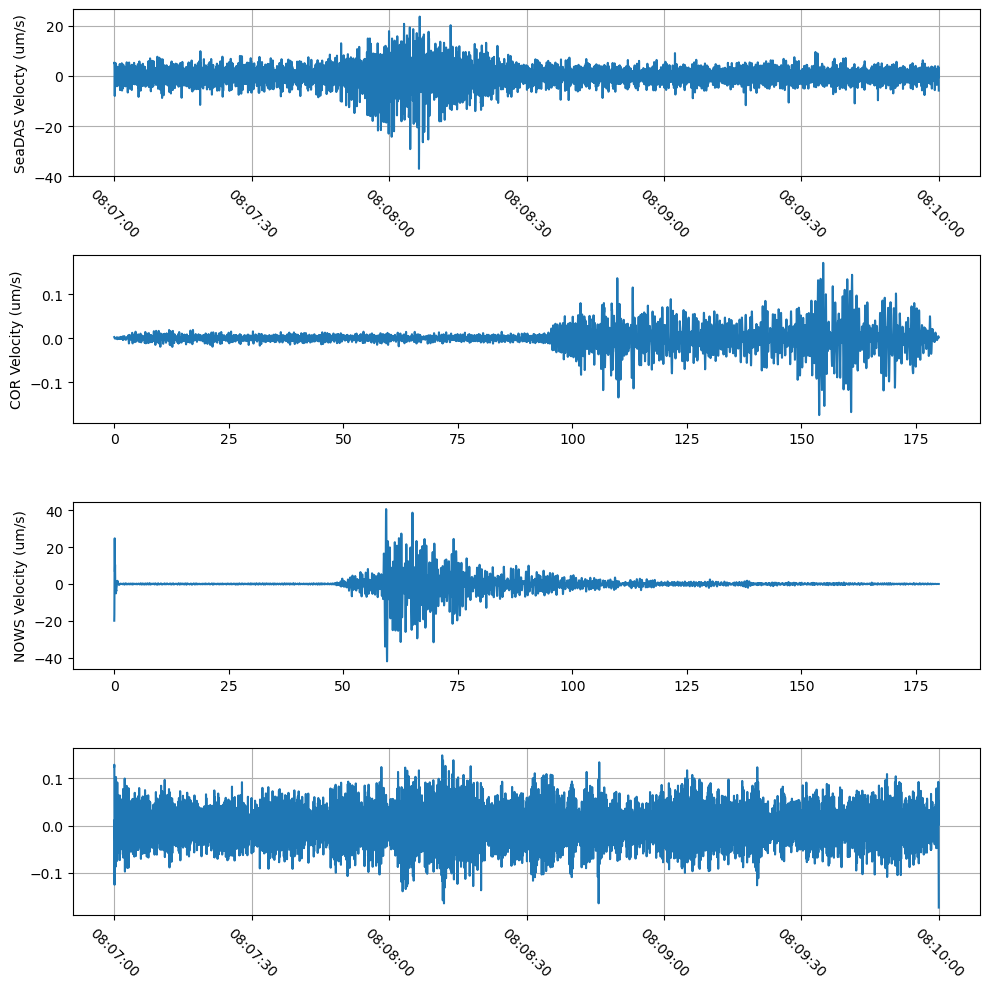

In [22]:
fig,axs = plt.subplots(3,1,figsize=(10,10))

ax = plt.subplot(4,1,1)
plt.plot(dates,vx*1e6)
plt.ylabel('SeaDAS Velocty (um/s)')
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelrotation = -45)
plt.grid()

plt.subplot(4,1,2)
# plt.plot(exx_cc)
# plt.ylabel('Phase (unitless)')
for tr in st2:
    plt.plot(tr.times(),tr.data * 1e6)
fig.patch.set_facecolor('w')
plt.ylabel('COR Velocity (um/s)')

plt.subplot(4,1,3)
for tr in st:
    plt.plot(tr.times(),tr.data*1e6)
plt.ylabel('NOWS Velocity (um/s)')

ax=plt.subplot(4,1,4)
ax.plot(dates,vx_all[:,1]*1e6)
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelrotation = -45)
plt.grid()

plt.tight_layout()
plt.show()

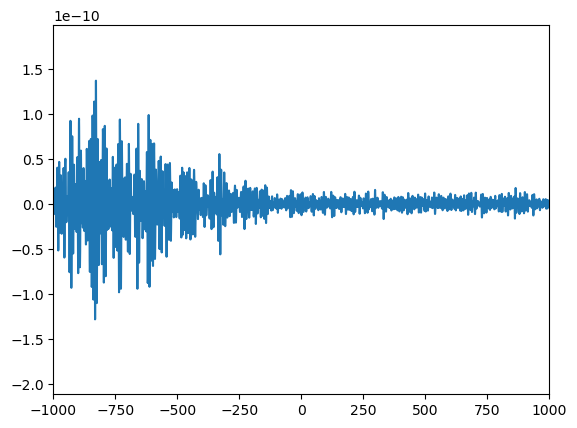

In [23]:
fig,ax=plt.subplots()
xc = np.correlate(st[0].data,st2[0].data,mode='full')
plt.plot(np.linspace(-3000,3000,len(xc)),xc)
plt.xlim((-1000,1000))
plt.show()